# 2. odovzdanie
**termin: 18.4.2020**
- strucny opis prac inych autorov = related work 2 az 3 zdroje (1-2 vedecke)
    - clanky pracujuce s rovnakym datasetom, podobnou ulohou (nasa domena / podobna)
    - nevedecky zdroj - nieco z kagglu, blog ...nieco co viem odcitovat
    - zhrnutie: co dosiahli, ake data, ake algoritmy... mozme sa porovnat?
- predspracovanie
- DM metody
    - ake metody pouzijeme - regresia: linearna, NN, DST ...
- prvotne experimenty
    - prototyp na zahodenie
- vyhodnocovanie
    - praca v dalsej faze
    
### predpracovanie a vyber atributov (realizovanie scenara z analyzy)
- zjednotit formaty dat, oprava chybnych hodnot, ouliers (chyba/real), chybajuce hodnoty (priemerom, medianom, knn)
- transformacia dat (kategoricke na numericke)
- feature engineering
    - z existujucich crt odvodit nove
    - kombinacia existujucich
    - domenove znalosti
- feature selection
    - vyber podmnoziny atributov / crt
    - niektore robia same: lin. regresia, DST, RDF
    - filter (vyber pred trenovanim), wrapper (vyber naviazany na trenovany model), embed
    
- rozdelenie dat - train, valid, test split
- metriky vyhodnocovania (regresia - RMSE)

sablona: https://www.springer.com/gp/computer-science/lncs/conference-proceedings-guidelines?countryChanged=true

In [144]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score

## Nacitanie dat

In [120]:
df = pd.read_csv('data/cars_raw.csv').drop('Unnamed: 0', axis=1)
df.head(3)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50


## Predspracovanie dat
- na zaklade analyzy a popisu chyb

### Konvertovanie atributov na numericke hodnoty *Power, Engine*

In [121]:
def convert_str_to_num(column):
    df[column] = df[column].apply(lambda x: str(x).split()[0])
    df[column] = pd.to_numeric(df[column], errors='coerce')

In [122]:
convert_str_to_num('Power')
convert_str_to_num('Engine')

### Vytvorenie novej crty - *Manufacturer*

In [123]:
df['Manufacturer'] = df['Name'].apply(lambda x: str(x).split()[0])

### Vytvorenie novej crty - *Price_km*
- na zaklade atributu Mileage
- cena paliva za 1 kilometer v indickych rupiach [ https://www.mypetrolprice.com/2/Fuel-prices-in-Delhi ]
- elektro-vozidla nemaju Mileage udaj, ale su len 2

In [124]:
def calculate_price_per_km(df):
    petrol_price = 69.63
    diesel_price = 62.33
    cng_price = 42
    lpg_price = 744
    electric_price = 0

    if df[0]=='Petrol':
        return petrol_price * df[1]
    elif df[0]=='Diesel':
        return diesel_price * df[1]
    elif df[0]=='CNG':
        return cng_price * df[1]
    elif df[0]=='LPG':
        return lpg_price * df[1]

In [125]:
convert_str_to_num('Mileage')
df['Price_km'] = df[['Fuel_Type', 'Mileage']].apply(calculate_price_per_km, axis = 1)

### Odstranenie zbytocnych atributov - *New_Price, Mileage*

In [126]:
df = df.drop(columns=["New_Price"], axis=1)
df = df.drop(columns=["Mileage"], axis=1)

## Rozdelenie na train-test

In [127]:
# x_train, x_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'Price'], df['Price'], test_size=0.2, random_state=42)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

## Normalizacia hodnot
- 0 sedadiel nahradime poctom sedadiel rovnakeho auta, ak nie je tak rovnakej znacky
- extremne hodnoty kilometrov doplnime priemerom kilometrov aut rovnakeho roku vyroby (stihli najazdit cca rovnako)

### Doplnenie nulovych hodnot Seats

In [130]:
def fill_seats(df, null_rows):
    for index, row in null_rows.iterrows():
        a = df_train[df_train['Seats'].notnull() & df_train['Seats']!=0].loc[df_train['Name']==row['Name']]
        if not (a.empty):
            df.at[index, 'Seats'] = a['Seats'].mode()[0]
        else:
            df.at[index, 'Seats'] = df_train[df_train['Manufacturer']==row["Manufacturer"]]['Seats'].mode()[0]

In [131]:
null_rows = df_train[(df_train['Seats']==0) | (df_train['Seats'].isna())]
nulls = len(null_rows)
fill_seats(df_train, null_rows)

null_rows = df_test[(df_test['Seats']==0) | (df_test['Seats'].isna())]
nulls += len(null_rows)
fill_seats(df_test, null_rows)

print(f"Povodny pocet nulovych hodnot: {nulls}.")
print(f"Aktualny pocet nulovych hodnot: {len(df_train[(df_train['Seats']==0) | (df_train['Seats'].isna())]) + len(df_test[(df_test['Seats']==0) | (df_test['Seats'].isna())])}.")

Povodny pocet nulovych hodnot: 0.
Aktualny pocet nulovych hodnot: 0.


### Doplnenie a korekcia Kilometers_Driven

In [132]:
def replace_kilometers(df, null_rows):
    for index, row in null_rows.iterrows():
        df.at[index, 'Kilometers_Driven'] = df_train[df_train['Year']==row["Year"]]['Kilometers_Driven'].mean()

In [133]:
null_rows = df_train[df_train['Kilometers_Driven']>1000000]
nulls = len(null_rows)
replace_kilometers(df_train, null_rows)

null_rows = df_test[df_test['Kilometers_Driven']>1000000]
nulls = len(null_rows)
replace_kilometers(df_test, null_rows)

print(f"Povodny pocet nulovych hodnot: {nulls}.")
print(f"Aktualny pocet nulovych hodnot: \
{len(df_train[df_train['Kilometers_Driven']>1000000]) + len(df_test[df_test['Kilometers_Driven']>1000000])}.")

Povodny pocet nulovych hodnot: 1.
Aktualny pocet nulovych hodnot: 0.


### Doplnenie Engine

In [134]:
def fill_null_Engine(df, null_rows):
    for index, row in null_rows.iterrows():
        a = df_train[df_train['Engine'].notnull()].loc[df_train['Name'] == row['Name']]
        if not (a.empty):
            df.at[index, 'Engine'] = a['Engine'].iloc[0]

In [135]:
null_rows = df_train[df_train['Engine'].isnull()]
nulls = len(null_rows)
fill_null_Engine(df_train, null_rows)

null_rows = df_test[df_test['Engine'].isnull()]
nulls += len(null_rows)
fill_null_Engine(df_test, null_rows)

print(f"Povodny pocet nulovych hodnot: {nulls}.")
print(f"Aktualny pocet nulovych hodnot: \
{len(df_train[df_train['Engine'].isnull()]) + len(df_test[df_test['Engine'].isnull()])}.")

Povodny pocet nulovych hodnot: 36.
Aktualny pocet nulovych hodnot: 31.


### Doplnenie Power

In [136]:
def fill_null_Power(df, null_rows):
    for index, row in null_rows.iterrows():
        a = df_train[df_train['Power'].notnull()].loc[df_train['Name'] == row['Name']]
        b = a.loc[a['Engine'] == row['Engine']]
        if not (b.empty):
            df.at[index, 'Power'] = a['Power'].iloc[0]
            

In [137]:
null_rows = df_train[df_train['Power'].isnull()]
nulls = len(null_rows)
fill_null_Power(df_train, null_rows)

null_rows = df_test[df_test['Power'].isnull()]
nulls += len(null_rows)
fill_null_Power(df_test, null_rows)

print(f"Povodny pocet nulovych hodnot: {nulls}.")
print(f"Aktualny pocet nulovych hodnot: \
{len(df_train[df_train['Power'].isnull()]) + len(df_test[df_test['Power'].isnull()])}.")

Povodny pocet nulovych hodnot: 143.
Aktualny pocet nulovych hodnot: 113.


### Odstranenie outlierov
- pri KM_Driven, Engine, Power
- podla analyzy to ale nema vyznam

In [235]:
def quantile_replace(column):
    q01 = df_train[column].quantile(0.01)
    q99 = df_train[column].quantile(0.99)

    df_train[column] = df_train[column].apply(lambda x: q99 if x > q99 
                                            else q01 if x < q01 else x)
    df_test[column] = df_test[column].apply(lambda x: q99 if x > q99 
                                            else q01 if x < q01 else x)

In [236]:
# quantile_replace('Kilometers_Driven')

## Ulozenie a nacitanie opravenych dat

In [138]:
# ulozenie
df_train.to_csv('data/cars_train.csv')
df_test.to_csv('data/cars_test.csv')

In [139]:
# nacitanie a vypis
df_train = pd.read_csv('data/cars_train.csv').drop('Unnamed: 0', axis=1)
df_train.head(3)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Engine,Power,Seats,Price,Manufacturer,Price_km
0,Chevrolet Beat LS,Delhi,2011,76155,Petrol,Manual,First,1199.0,79.40,5.0,1.95,Chevrolet,1295.1180
1,Ford EcoSport 1.5 TDCi Titanium,Coimbatore,2014,64637,Diesel,Manual,First,1498.0,98.59,5.0,7.52,Ford,1419.2541
2,Maruti Vitara Brezza ZDi,Kolkata,2018,2900,Diesel,Manual,First,1248.0,88.50,5.0,8.75,Maruti,1514.6190


In [140]:
# nacitanie a vypis
df_test = pd.read_csv('data/cars_test.csv').drop('Unnamed: 0', axis=1)
df_test.head(3)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Engine,Power,Seats,Price,Manufacturer,Price_km
0,Maruti Swift Dzire VDI,Hyderabad,2013,69000,Diesel,Manual,First,1248.0,74.0,5.0,5.75,Maruti,1458.522
1,Mahindra Scorpio 1.99 S4 Plus,Kochi,2017,26741,Diesel,Manual,First,1997.0,120.0,7.0,10.08,Mahindra,959.882
2,Mahindra XUV500 W8 2WD,Delhi,2014,86000,Diesel,Manual,First,2179.0,140.0,7.0,7.85,Mahindra,941.183


## Prvotne experimenty

In [146]:
features = ['Kilometers_Driven', 'Price_km', 'Power', 'Seats', 'Engine']

df_train = df_train.dropna()
df_test = df_test.dropna()

x_train = df_train[features]
x_test = df_test[features]
y_train = df_train['Price']
y_test = df_test['Price']

In [149]:
model = LinearRegression()
model.fit(x_train, y_train)
print(model.get_params())

predict = model.predict(x_test)
print("RMSE: ", mean_squared_error(y_test, predict))
# print("RMSLE: ", mean_squared_log_error(y_test, predict))
print("R2: ", r2_score(y_test, predict))  

# RMSLE

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}
RMSE:  46.957912432132574
R2:  0.6214070377178462


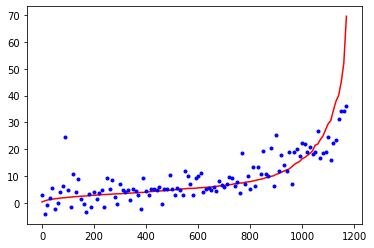

In [148]:
dfl = pd.DataFrame(predict, y_test)
dfl = dfl.sort_values(by='Price')

l = list(range(0, y_test.count()))
plt.plot(l[::10], dfl.index[::10], c='red')     # y_test
plt.plot(l[::10], dfl[0][::10], '.', c='blue')  # predict